## Task 1: Understanding Unit Commitment and optimization model
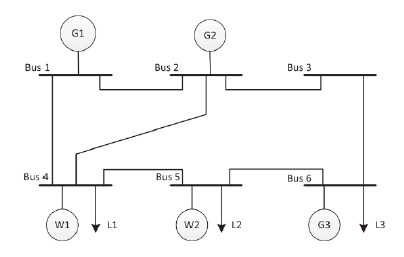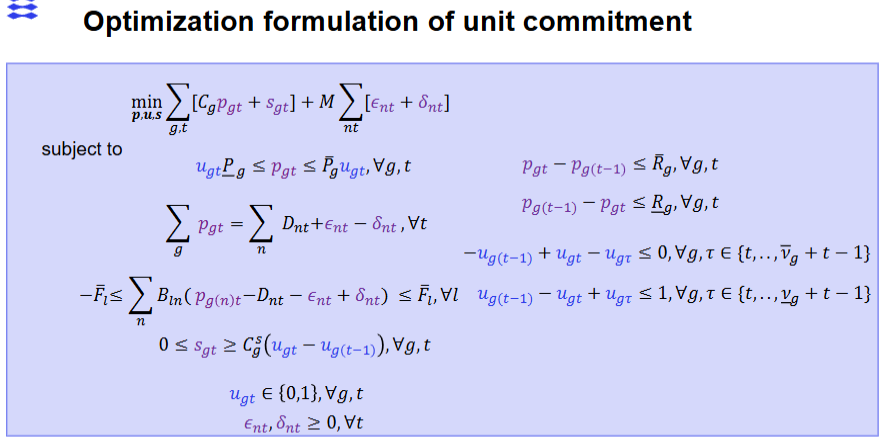

In [ ]:
import gurobipy as gp
from gurobipy import GRB

## Task 2: Data preperation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
B = pd.read_csv('data/B (power transfer factor of each bus to each line).csv', sep=';')
P_max = pd.read_csv('data\Maximum production of generating units.csv')
P_min = pd.read_csv('data\Minimum production of generating units.csv')
min_downtime = pd.read_csv('data\Minimum down time of generating units.csv')
min_uptime = pd.read_csv('data\Minimum up time of generating units.csv')
c = pd.read_csv('data\Production cost of generating units.csv')
c_startup = pd.read_csv('data\Start-up cost of generating units.csv')
ramp = pd.read_csv('data\Ramping rate of generating units.csv')
F = pd.read_csv('data\Transmission capacity of lines.csv')

# Load wind data
W_cap = pd.read_csv('data/Capacity of wind farms.csv')
W1 = pd.read_csv('data\W1.csv', skiprows=3) 
W2 = pd.read_csv('data\W2.csv', skiprows=3)

# Scale wind data
W1 = np.array(W1.iloc[:,2]) * W_cap.values[0]
W2 = np.array(W2.iloc[:,2]) * W_cap.values[1]
W = np.vstack((W1, W2)).T

# Load demand data
D = pd.read_csv('data\ConsumptionPerGridarea.csv', sep=';', decimal=',')
D = D.loc[D['GridCompany'].isin([131, 344, 16])]
D["HourDK"] = pd.to_datetime(D["HourDK"])
D = D.loc[D["HourDK"].dt.year == 2021]
D = D.pivot_table(index = "HourDK", columns = "GridCompany", values = "FlexSettledConsumption")

D_cap = pd.read_csv('data\Loads.csv')
D = (D/np.max(D, axis=0)) * D_cap.values.T

D1 = np.array(D1.iloc[:,2]) * D_cap.values[0]
D2 = np.array(D2.iloc[:,2]) * D_cap.values[1]
D3 = np.array(D3.iloc[:,2]) * D_cap.values[2]
# D = np.vstack((D1, D2, D3)).T


# Split into training, validation and test sets
train_test_fraction = 0.8
train_val_fraction = 0.8
n = len(W1)
train_test_split = int(n * train_test_fraction)
train_val_split = int(train_test_split * train_val_fraction)

D_train = D[:train_test_split]
D_train_train = D[:train_val_split]
D_val = D_train[train_val_split:]
D_test = D[train_test_split:]

W_train = W[:train_test_split]
W_train_train = W[:train_val_split]
W_val = W_train[train_val_split:]
W_test = W[train_test_split:]

# Run simluations

# Save results



## Task 3: Train classifiers

<Axes: xlabel='HourDK'>

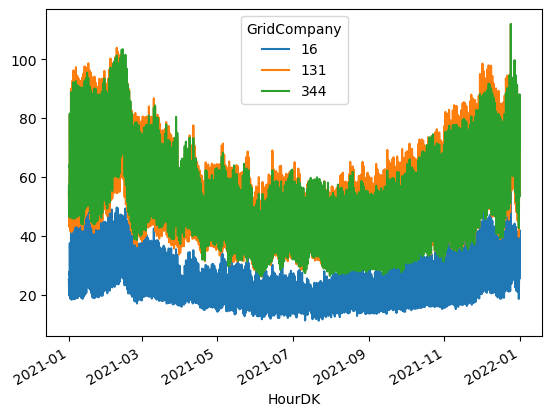

In [98]:
# Train classifier

# Create pivot table of demand. Grid area as columns, time as rows
D["FlexSettledConsumption"]

0           470,480000
1        243350,735000
2        210473,622000
3           504,450000
4        255121,675000
             ...      
26275    237313,090000
26276    216010,904000
26277       461,760000
26278    249146,406000
26279    224178,717000
Name: FlexSettledConsumption, Length: 26280, dtype: object

## Task 4: Evaluate models